In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
"""Parameterization"""
import numpy as np
t = np.arange(1, 310+1, 1) # array of timepoints at which to compute the antibody concentration
N = 10 # number of antibody classes
t_max = 14*np.ones(N) # time for the peak of antibody concentration for each antibody class
t_half = 48*np.ones(N) # antibody half-life for all antibody classes, respecively
params_dic = {"t_max":t_max, "t_half":t_half}

In [3]:
"""Compute Antibody concentration"""
from Methods.PK import Antibody
is_log = False # if True, it returns the log of the antibody concentration
dataname = "Ab_%d"%N
solver = "lm" # root solver method for finding absorption rate ka (see scipy.optimize.root)
c_t, c_dframe, ka, ke = Antibody(t = t, params_dic = params_dic, is_log = is_log, save_to = "Data/"+dataname+".csv", ka_solver = solver)
print(c_dframe, "k_a:", ka, "k_e:", ke)


 k_a was found correctly: True 

     Days      Ab_1      Ab_2      Ab_3      Ab_4      Ab_5      Ab_6  \
0       1  0.223579  0.223579  0.223579  0.223579  0.223579  0.223579   
1       2  0.402809  0.402809  0.402809  0.402809  0.402809  0.402809   
2       3  0.545897  0.545897  0.545897  0.545897  0.545897  0.545897   
3       4  0.659540  0.659540  0.659540  0.659540  0.659540  0.659540   
4       5  0.749201  0.749201  0.749201  0.749201  0.749201  0.749201   
..    ...       ...       ...       ...       ...       ...       ...   
305   306  0.015875  0.015875  0.015875  0.015875  0.015875  0.015875   
306   307  0.015648  0.015648  0.015648  0.015648  0.015648  0.015648   
307   308  0.015423  0.015423  0.015423  0.015423  0.015423  0.015423   
308   309  0.015202  0.015202  0.015202  0.015202  0.015202  0.015202   
309   310  0.014984  0.014984  0.014984  0.014984  0.014984  0.014984   

         Ab_7      Ab_8      Ab_9     Ab_10  
0    0.223579  0.223579  0.223579  0.223579

(<Figure size 1400x700 with 1 Axes>,
 <AxesSubplot:xlabel='time (days)', ylabel='$c_t$ (normalized)'>)

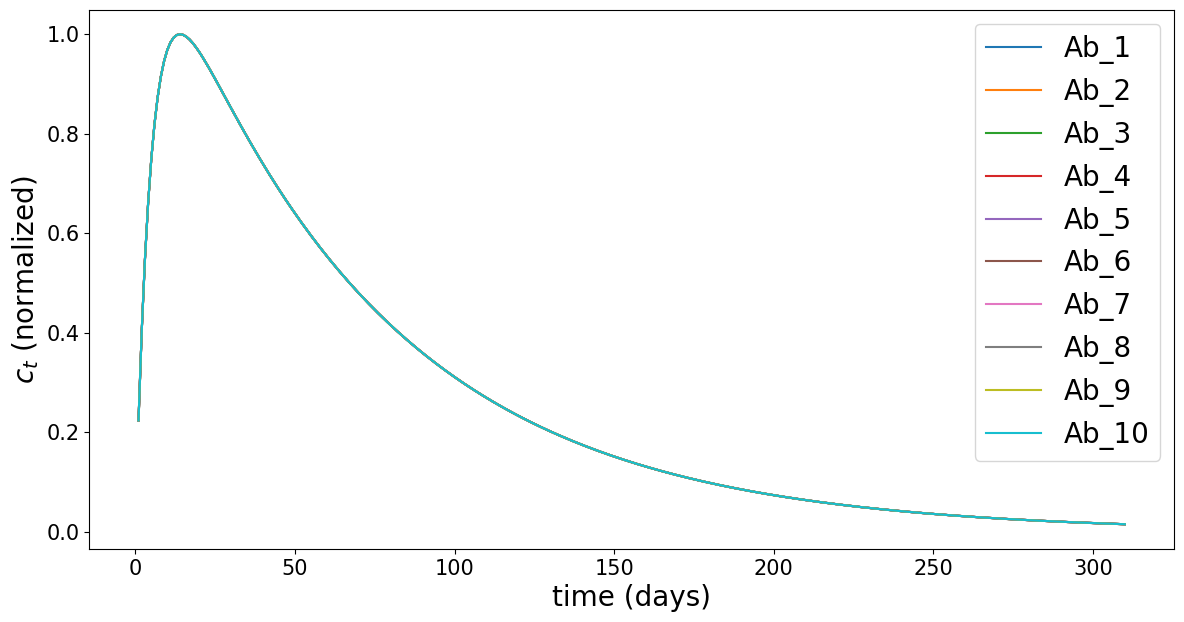

In [4]:
"""Plot Antibody concentration only if t is an array and save, default png but add extension .pdf to save as pdf"""
from Methods.figure_settings import Display
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (14, 7) # figure (width, height)
labels = c_dframe.columns[1:] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "$c_t$ (normalized)" # name of variable on y axis
Display(t, c_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/"+dataname+".pdf",
        xval = xval, yval = yval)

In [5]:
"""Set up the vaccine efficacy data which is used for fitting"""
from Methods.VE import sqrt_diff, vaccine_efficacy_four_antibodies, vaccine_efficacy_n_antibodies
import matplotlib.pyplot as plt

days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

[0.20118341]
[0.51119209]
[0.83920279]
[1.1806477]
[1.5296183]
[1.88255499]
[2.23773022]
[2.59431082]
[2.95166293]
[3.30958921]


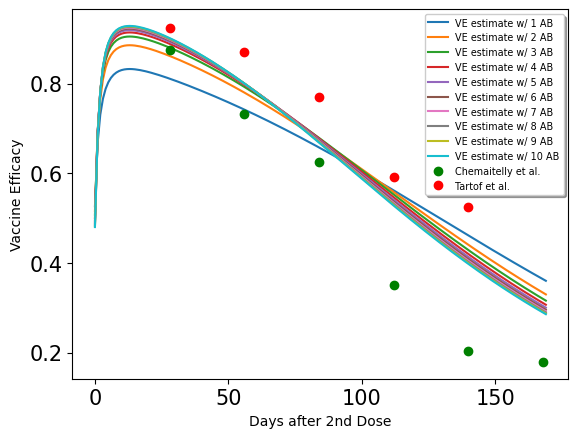

In [6]:
"""Fit the data using n=1,2,3,...,10 antibodies"""
from scipy.optimize import root

guess = 0.2
for n in range(1,len(t_max)+1):
    ic50 = root(sqrt_diff, guess, args = (days, ve_data, n, c_dframe), method = "lm").x
    print(ic50)
    ve_estimate = np.zeros(170)
    for i in range(170):
        antibody_level = c_dframe.loc[i][1:n+1]
        ve_estimate[i] = vaccine_efficacy_n_antibodies(antibody_level, ic50)
    plt.plot(range(170), ve_estimate, label = "VE estimate w/ "+ str(n) + " AB")

plt.plot(days, ve_data_1,'go', label = "Chemaitelly et al.")
plt.plot(days[0:5], ve_data_2, 'ro', label = "Tartof et al.")
plt.xlabel("Days after 2nd Dose")
plt.ylabel("Vaccine Efficacy")
plt.legend(loc='upper right', shadow=True, fontsize='x-small')

([<matplotlib.axis.XTick at 0x7fd73842e730>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

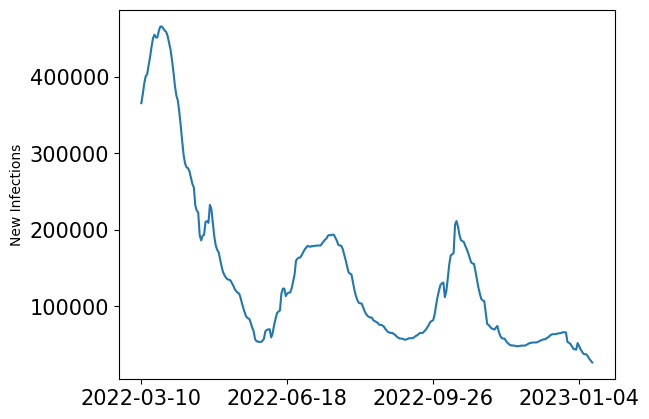

In [7]:
import pandas as pd
import datetime as dt
df = pd.read_csv('Data/caseAscertainmentTable.csv')
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df['date']]
infection_data = df['newCases'].values
population_total = df['pop'].values - np.cumsum(infection_data)
plt.plot(x, infection_data)
plt.ylabel("New Infections")
plt.xticks([x[0],x[100],x[200], x[300]])

In [8]:
""" Calculation of expected reduction in neutralization probability """
from Methods.VE import expected_reduction_infection_prob
days = range(310)
reduction_over_time = np.zeros(310)
for day in days:
    observation_period = days[0:day]
    reduction_over_time[day] = expected_reduction_infection_prob(ic50, observation_period, infection_data[0:day], population_total[0:day], len(t_max), c_dframe)
print("Used ic50", ic50)


Used ic50 [3.30958921]


([<matplotlib.axis.XTick at 0x7fd7487a83a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

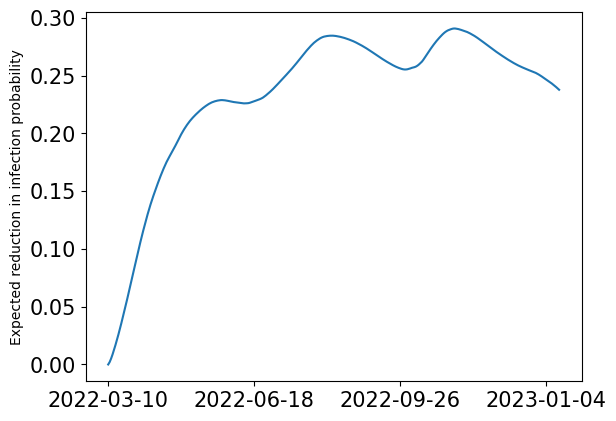

In [9]:
plt.plot(x, reduction_over_time)
plt.ylabel("Expected reduction in infection probability")
plt.xticks([x[0],x[100],x[200], x[300]])

In [10]:
"""Data on Immune Efficacy against COV19 Wild Type """
days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

In [11]:
""" Projection of Immune Efficacy as a function of COV19 variant proportions """
""" Same as Expected reduction in infection probability but considering several variants """
np.random.seed(7)
infected = infection_data
tot_pop = df['pop'].values - np.cumsum(infected)
variant_name = ["Var 1", "Var 2", "Var 3", "Var 4"]
variant_proportion = np.tile(np.array([0.10, 0.30, 0.30, 0.30]), (len(t), 1)) # variant proportion might change over time
#variant_proportion = np.tile(np.array([0.25, 0.25, 0.25, 0.25]), (len(t), 1))
fold_resistance = [1.2, 1.4, 1.6, 1.8]
#fold_resistance = [1., 1., 1., 1.]

variant_data = {"name":variant_name, "proportion":variant_proportion, "fold resistance":fold_resistance}
antibody_data = {"t_max": t_max, "t_half":t_half, "day_activation":0} # assuming antibodies are activated 0 days after infection
VE_data_wild = {"days":days, "Efficacy":ve_data}

In [12]:
from Methods.IE_Projection import IE_Per_Variant
IE_dic = IE_Per_Variant(t, infected, tot_pop, antibody_data, VE_data_wild, variant_data)


 k_a was found correctly: True 

ic50 of wild-type [3.30958921]


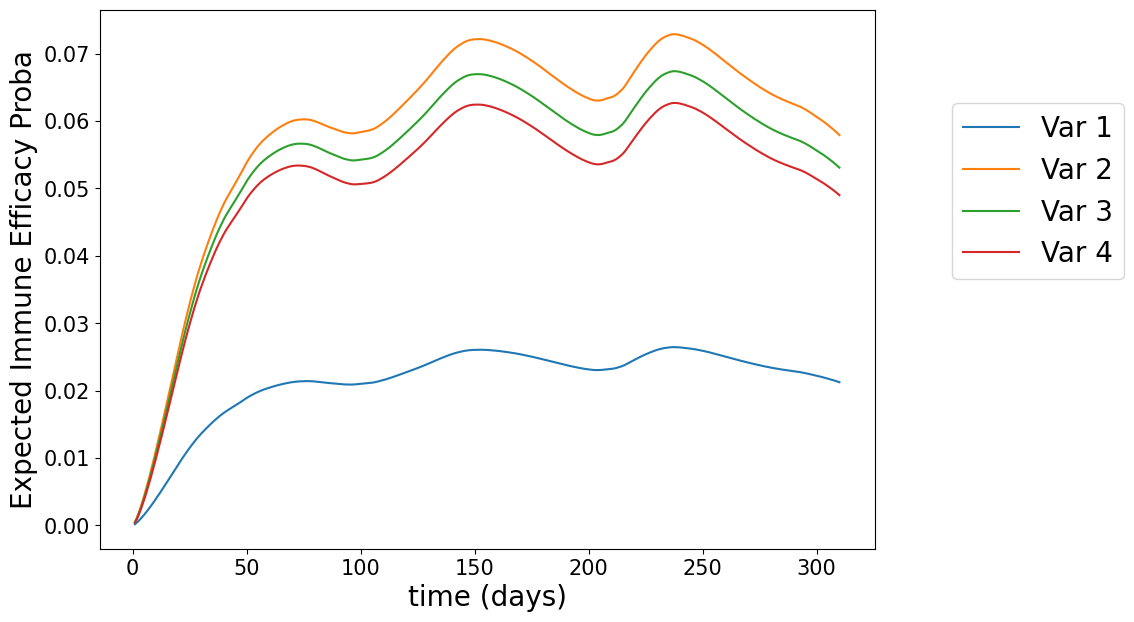

In [13]:
"""Plot Projection, default png but add extension .pdf to save as pdf"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
labels = variant_name # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Immune Efficacy Proba" # name of variable on y axis
prob_neut_t = np.row_stack(tuple([IE_dic[variant_name[i]] for i in range(len(variant_name))]))
Display(t, prob_neut_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/IE_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))

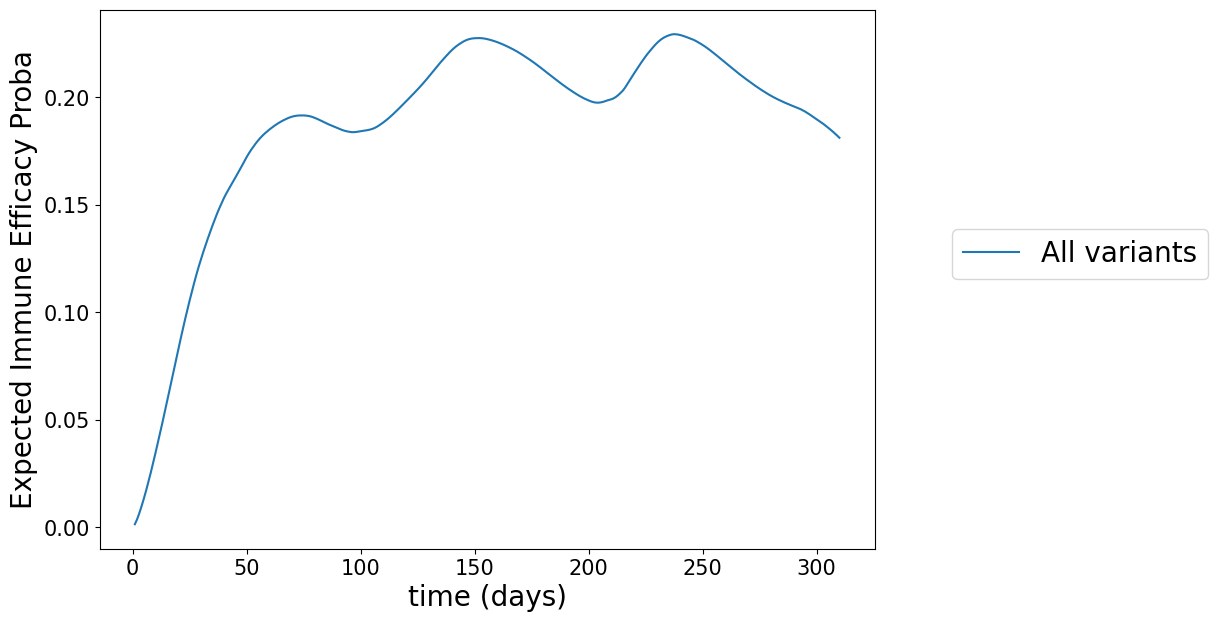

In [14]:
"Total projected Immune Efficacy proba"
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
labels = ["All variants"] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Immune Efficacy Proba" # name of variable on y axis
IE_t = np.row_stack(tuple([IE_dic[variant_name[i]] for i in range(len(variant_name))]))
tot_IE_t = np.array([np.sum(IE_t, axis = 0)])
Display(t, tot_IE_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/Total_IE_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))